# Task 3: Helper notebook for loading the data and saving the predictions

In [2]:
import pickle
import gzip
import numpy as np
import os

### Helper functions

In [3]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [4]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

### Load data, make predictions and save prediction in correct format

In [5]:
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")
# samples = load_zipped_pickle("sample.pkl")

In [6]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def preprocess_item(item):
    '''
    This function preprocesses an item. It returns the names of the item, the video frames and the mask frames.
    '''
    item_video_frames = []
    item_mask_frames = []
    item_names = []
    video = item['video']
    name = item['name']
    height, width, n_frames = video.shape
    mask = np.zeros((height, width, n_frames), dtype=bool)
    for frame in item['frames']:
        mask[:, :, frame] = item['label'][:, :, frame]
        video_frame = video[:, :, frame]
        mask_frame = mask[:, :, frame]
        video_frame = np.expand_dims(video_frame, axis=2).astype(np.float32)
        mask_frame = np.expand_dims(mask_frame, axis=2).astype(np.int32)
        item_video_frames.append(video_frame)
        item_mask_frames.append(mask_frame)
        item_names.append(name)
    return item_names, item_video_frames, item_mask_frames

def preprocess_train_data(data, select='all'):
    '''
    This function preprocesses the training data. It returns the names of the items, the video frames and the mask frames. 
    The select parameter can be 'all', 'expert' or 'amateur'. 
    '''
    video_frames = []
    mask_frames = []
    names = []
    for item in tqdm(data):
        if select == 'all':
            item_names, item_video_frames, item_mask_frames = preprocess_item(item)
        elif select == 'expert':
            if item['dataset'] == 'expert':
                item_names, item_video_frames, item_mask_frames = preprocess_item(item)
            else: continue
        elif select == 'amateur':
            if item['dataset'] == 'amateur':
                item_names, item_video_frames, item_mask_frames = preprocess_item(item)
            else: continue
        else: raise ValueError('Invalid select')
        video_frames += item_video_frames
        mask_frames += item_mask_frames
        names += item_names

    return names, video_frames, mask_frames

def preprocess_test_data(data):
    video_frames = []
    names = []
    for item in tqdm(data):
        video = item['video']
        video = video.astype(np.float32).transpose((2, 0, 1))
        video = np.expand_dims(video, axis=3)
        video_frames += list(video)
        names += [item['name'] for _ in video]
    return names, video_frames

In [7]:
# Extract the expert and amateur training data separately
train_names_expert, train_videos_expert, train_masks_expert = preprocess_train_data(train_data, select='expert')
train_names_amateur, train_videos_amateur, train_masks_amateur = preprocess_train_data(train_data, select='amateur')
# Extract test data
test_names, test_videos = preprocess_test_data(test_data)

100%|██████████| 20/20 [00:01<00:00, 16.48it/s]


In [8]:
# check how many frames we have for each dataset
num_expert_videos = len(train_videos_expert)
num_amateur_videos = len(train_videos_amateur)
num_test_videos = len(test_videos)

print(f"Number of expert videos: {num_expert_videos}")
print(f"Number of amateur videos: {num_amateur_videos}")
print(f"Number of test videos: {num_test_videos}")

Number of expert videos: 57
Number of amateur videos: 138
Number of test videos: 1507


So we have 19 expert videos containing 57 labeled frames and 46 amateur videos containing 138 labeled frames.

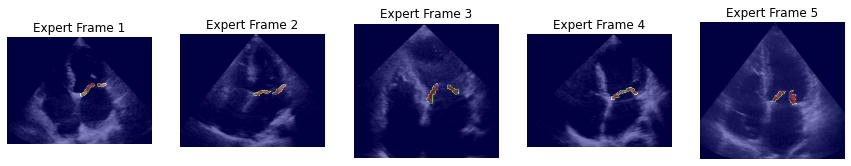

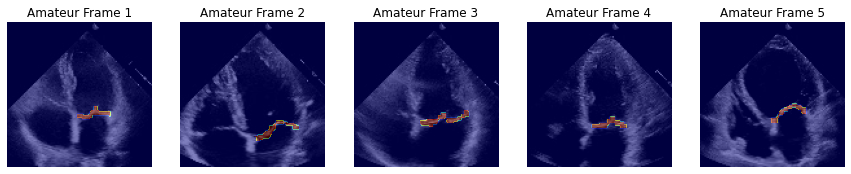

In [9]:
import random

import matplotlib.pyplot as plt

# Function to plot frames with masks
def plot_frames_with_masks(videos, masks, num_frames, title):
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    selected_indices = random.sample(range(0, len(videos), 3), num_frames)
    for i, idx in enumerate(selected_indices):
        axes[i].imshow(videos[idx][:, :, 0], cmap='gray')
        axes[i].imshow(masks[idx][:, :, 0], cmap='jet', alpha=0.5)
        axes[i].set_title(f'{title} Frame {i+1}')
        axes[i].axis('off')
    plt.show()

# Plot 5 random frames from expert dataset
plot_frames_with_masks(train_videos_expert, train_masks_expert, 5, 'Expert')

# Plot 5 random frames from amateur dataset
plot_frames_with_masks(train_videos_amateur, train_masks_amateur, 5, 'Amateur')

Minimum frame size: 112x112
Maximum frame size: 731x863


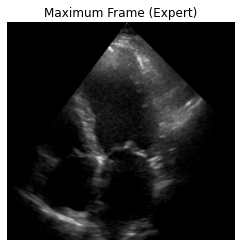

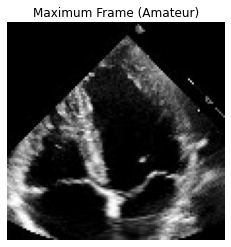

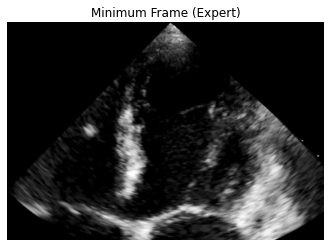

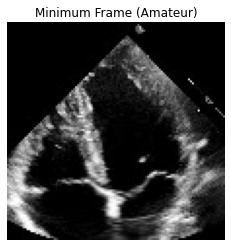

In [10]:
# Check minimum frame size
min_height_expert = min([frame.shape[0] for frame in train_videos_expert])
min_width_expert = min([frame.shape[1] for frame in train_videos_expert])

min_height_amateur = min([frame.shape[0] for frame in train_videos_amateur])
min_width_amateur = min([frame.shape[1] for frame in train_videos_amateur])

min_height = min(min_height_expert, min_height_amateur)
min_width = min(min_width_expert, min_width_amateur)

print(f"Minimum frame size: {min_height}x{min_width}")

# Check maximum frame size
max_height_expert = max([frame.shape[0] for frame in train_videos_expert])
max_width_expert = max([frame.shape[1] for frame in train_videos_expert])

max_height_amateur = max([frame.shape[0] for frame in train_videos_amateur])
max_width_amateur = max([frame.shape[1] for frame in train_videos_amateur])

max_height = max(max_height_expert, max_height_amateur)
max_width = max(max_width_expert, max_width_amateur)

print(f"Maximum frame size: {max_height}x{max_width}")

# Function to plot a frame
def plot_frame(frame, title):
    plt.imshow(frame[:, :, 0], cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot the maximum frame
max_frame_expert = train_videos_expert[np.argmax([frame.shape[0] for frame in train_videos_expert])]
max_frame_amateur = train_videos_amateur[np.argmax([frame.shape[0] for frame in train_videos_amateur])]
plot_frame(max_frame_expert, 'Maximum Frame (Expert)')
plot_frame(max_frame_amateur, 'Maximum Frame (Amateur)')

# Plot the minimum frame
min_frame_expert = train_videos_expert[np.argmin([frame.shape[0] for frame in train_videos_expert])]
min_frame_amateur = train_videos_amateur[np.argmin([frame.shape[0] for frame in train_videos_amateur])]
plot_frame(min_frame_expert, 'Minimum Frame (Expert)')
plot_frame(min_frame_amateur, 'Minimum Frame (Amateur)')

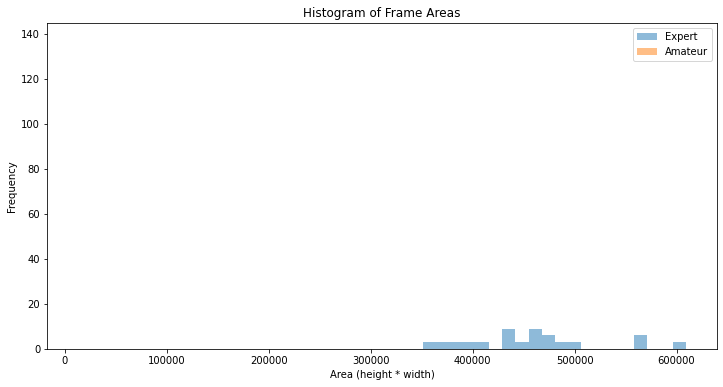

In [15]:
# Calculate the areas of the frames
areas_expert = [frame.shape[0] * frame.shape[1] for frame in train_videos_expert]
areas_amateur = [frame.shape[0] * frame.shape[1] for frame in train_videos_amateur]

# Plot histograms
plt.figure(figsize=(12, 6))

plt.hist(areas_expert, bins=20, alpha=0.5, label='Expert')
plt.hist(areas_amateur, bins=20, alpha=0.5, label='Amateur')

plt.xlabel('Area (height * width)')
plt.ylabel('Frequency')
plt.title('Histogram of Frame Areas')
plt.legend(loc='upper right')

plt.show()

In [ ]:
# Check the sizes of the test frames
test_frame_sizes = [(frame.shape[0], frame.shape[1]) for frame in test_videos]

# Print the sizes of the test frames
for i, size in enumerate(test_frame_sizes):train
    print(f"Test frame {i+1}: {size}")

Test frame 1: (586, 821)
Test frame 2: (586, 821)
Test frame 3: (586, 821)
Test frame 4: (586, 821)
Test frame 5: (586, 821)
Test frame 6: (586, 821)
Test frame 7: (586, 821)
Test frame 8: (586, 821)
Test frame 9: (586, 821)
Test frame 10: (586, 821)
Test frame 11: (586, 821)
Test frame 12: (586, 821)
Test frame 13: (586, 821)
Test frame 14: (586, 821)
Test frame 15: (586, 821)
Test frame 16: (586, 821)
Test frame 17: (586, 821)
Test frame 18: (586, 821)
Test frame 19: (586, 821)
Test frame 20: (586, 821)
Test frame 21: (586, 821)
Test frame 22: (586, 821)
Test frame 23: (586, 821)
Test frame 24: (586, 821)
Test frame 25: (586, 821)
Test frame 26: (586, 821)
Test frame 27: (586, 821)
Test frame 28: (586, 821)
Test frame 29: (586, 821)
Test frame 30: (586, 821)
Test frame 31: (586, 821)
Test frame 32: (586, 821)
Test frame 33: (586, 821)
Test frame 34: (586, 821)
Test frame 35: (586, 821)
Test frame 36: (586, 821)
Test frame 37: (586, 821)
Test frame 38: (586, 821)
Test frame 39: (586, 

In [10]:
from dataextractor import preprocess_train_data, resize_with_mask, pad_or_crop_with_mask

_, train_frames_amateur, train_masks_amateur = preprocess_train_data(select='amateur')
_, train_frames_expert, train_masks_expert = preprocess_train_data(select='expert')
train_frames_expert = [frame[:, :, 0] for frame in train_frames_expert]
train_masks_expert = [mask[:, :, 0] for mask in train_masks_expert]
train_frames_amateur, train_masks_amateur = resize_with_mask(train_frames_amateur, train_masks_amateur, target_size=(512, 512))
train_frames_amateur, train_masks_amateur = pad_or_crop_with_mask(train_frames_amateur, train_masks_amateur, target_size=(700, 700))
train_frames_expert, train_masks_expert = pad_or_crop_with_mask(train_frames_expert, train_masks_expert, target_size=(700, 700))

100%|██████████| 65/65 [00:01<00:00, 57.29it/s] 


In [11]:
# Check the shape of the elements in the train_frames_amateur
shapes_amateur = [frame.shape for frame in train_frames_amateur]
print(shapes_amateur)
# Check the shape of the elements in the train_masks_expert
shapes_expert = [mask.shape for mask in train_masks_expert]
print(shapes_expert)

[(700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (700, 700), (70

### From the flattented array, retrieve indices and length for submission format

In [ ]:
def get_sequences(arr):
    first_indices, last_indices, lengths = [], [], []
    n, i = len(arr), 0
    arr = [0] + list(arr) + [0]
    for index, value in enumerate(arr[:-1]):
        if arr[index+1]-arr[index] == 1:
            first_indices.append(index)
        if arr[index+1]-arr[index] == -1:
            last_indices.append(index)
    lengths = list(np.array(last_indices)-np.array(first_indices))
    return first_indices, lengths

### Create .csv in submission format

In [ ]:
import pandas as pd

df = pd.DataFrame({"id":ids, "value":[list(map(int, minili)) for minili in values]})
df.to_csv(f"mysubmissionfile_{THRESHOLD}.csv", index=False)